## Overview


### Data
#### Completed Elements:
1. Get Characters and WikiAPi links for characters in the books
2. Optain aliases for characters
3. Obtain chracter description/overview from  WikiApi

#### Missing Elements:
1. Format the rest of the books


### Network
#### Completed Elements:
1. Write functions that given af Chapter computed the network of characters in that chapter
2. 

#### Missing Elements:
1. Analyse the dynamic network of chracters over the books.
2. Compute centrality measures for the characters in the network
3. Community detection in the network for each Chapter
4. Test  

### Text
#### Completed Elements:
1. Function for character sentiments
2. Construct word clouds for character

#### Missing Elements:
1. Construct word clouds and sentiments for communities

### Harry Potter Dynamic Network 

In [1]:
# imports
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from tqdm import tqdm
import re



# Text libraries
import nltk
from nltk import tokenize
import pickle as pkl
import matplotlib.pyplot as plt


# Network libraries
import networkx as nx
import netwulf as nw
from community import community_louvain

# Custom libraries
from Utils.tokenize_function import stop_tokenize
from Utils.get_text import text_book

import os
os.getcwd(), os.path.exists("1.Dataset_files/Books/Book 1 - The Philosopher's Stone.txt")

# Flatten list function
def flatten(list_list : list) -> list:
    return [item for sublist in list_list for item in sublist]

# Data
1. Get Characters and WikiAPi links for characters in the books
2. Optain aliases for characters
3. Obtain chracter description/overview from  WikiApi
4. Download the books from the web
5. Format the rest of the books


#### 1.

In [4]:
# 1.

# Define Links for each books Character lists
Books =[
    #1
    'Harry_Potter_and_the_Philosopher%27s_Stone_(character_index)',
    #2
    'Harry_Potter_and_the_Chamber_of_Secrets_(character_index)',
    #3
    'Harry_Potter_and_the_Prisoner_of_Azkaban_(character_index)',
    #4
    'Harry_Potter_and_the_Goblet_of_Fire_(character_index)',
    #5
    'Harry_Potter_and_the_Order_of_the_Phoenix_(character_index)',
    #6
    'Harry_Potter_and_the_Half-Blood_Prince_(character_index)',
    #7
    'Harry_Potter_and_the_Deathly_Hallows_(character_index)'
]


In [5]:
# Define the function to get the data

def get_data(book, nr):

    # Get JSON data from the API
    query = requests.get(f'https://harrypotter.fandom.com/api.php?action=parse&page={book}&format=json').json()
    
    # Get the HTML data from the JSON
    HTML = query['parse']['text']['*']

    # Parse the HTML data
    soup = BeautifulSoup(HTML, 'html.parser')

    # Get rows of characters
    
    if nr < 3:
        Chars = soup.find_all('td')
    else:
        sub_Chars = soup.find_all('ul')[1:-1]
        Chars = []
        for sub_Char in sub_Chars:
            Chars.extend(sub_Char.find_all('li'))

    return Chars,soup


# Define the function to get name and link of each character

def get_character(Char_td):

    # Get the name of the character
    name = Char_td.find('a').text

    # Get the link of the character
    link = Char_td.find('a')['href']

    return name, link

# Define the function to get name, link for each character

def get_Char_td(Chars):

    # Initialize the list of names and links
    Names = []
    Links = []

    for char in Chars:

        # Check if character
        if char.find('a') == None:
            continue
    
        if char.find('a').get('class') != None:
            continue

        # Get the name and link of the character
        name, link = get_character(char)

        # Append the name and link to the list
        Names.append(name)
        Links.append(link)

    return Names, Links

# Define the function to get the data for each book

def get_all_data(Books):

    # Initialize the list of names and links
    Names = []
    Links = []

    # Get the data for each book
    for nr, book in enumerate(Books):
        print(f'Getting data for {book}...')
        # Get the data for each book
        Chars,_ = get_data(book, nr+1)

        # Get the name and link of each character
        Name, Link = get_Char_td(Chars)

        # Append the name and link to the list
        Names.append(Name)
        Links.append(Link)

        # print number of characters and first 5 characters
        print(f'Number of characters: {len(Name)}')

    #Names = flatten(Names)
    #Links = flatten(Links)

    return Names, Links

In [7]:
# Get Names and Links for each book
Names, Links = get_all_data(Books)

# Save as DataFrame
CharacterData = pd.DataFrame({'Name': Names, 'Link': Links})

# Save as Excel
CharacterData.to_excel('Temp/CharacterData.xlsx', index=True)

Getting data for Harry_Potter_and_the_Philosopher%27s_Stone_(character_index)...
Number of characters: 155
Getting data for Harry_Potter_and_the_Chamber_of_Secrets_(character_index)...
Number of characters: 65
Getting data for Harry_Potter_and_the_Prisoner_of_Azkaban_(character_index)...
Number of characters: 46
Getting data for Harry_Potter_and_the_Goblet_of_Fire_(character_index)...
Number of characters: 151
Getting data for Harry_Potter_and_the_Order_of_the_Phoenix_(character_index)...
Number of characters: 129
Getting data for Harry_Potter_and_the_Half-Blood_Prince_(character_index)...
Number of characters: 83
Getting data for Harry_Potter_and_the_Deathly_Hallows_(character_index)...
Number of characters: 82


#### 2.

In [11]:
# 2.

# load the data
NnL = pd.read_excel('Temp/CharacterData.xlsx',index_col=0)

# Define edge cases
edge_aliases = {0: 'Mr. Dursley', 1: 'Mrs. Dursley', 3: 'Mrs. Potter', 5: 'Mr. Potter', 7: 'My Lord',
                11: 'Dumbledore', 12: 'McGonagall', 13: 'Diggle', 14: 'Pomfrey',
                15: 'Hagrid', 18: 'Mrs. Figg', 21: 'Mr. Paws', 28: 'Boa Constrictor',
                37: 'Mr. Evans', 38: 'Mrs. Evans', 53: 'Quirrell', 57: 'Malfoy',
                62: 'Mr. Ollivander', 65: 'Mrs. Weasley', 69: 'Mr. Weasley',
                70: 'Longbottom', 78: 'Agrippa', 79: 'Ptolemy', 80: 'Grindelwald',
                90: 'Miss Granger', 91: 'Crabbe', 92: 'Goyle', 95: 'Friar',
                116: 'Nearly Headless Nick', 118: 'Mr. Finnigan', 119: 'Mrs. Finnigan', 
                121: 'Snape', 122: 'Filch', 123: 'Madam Hooch', 125: 'Mrs. Norris', 
                126: 'Professor Sprout', 127: 'Professor Binns', 130: 'Professor Flitwick', 
                132: 'Wood', 139: 'Flint', 140: 'Spinnet', 143: 'Pucey', 
                144: 'Higgs', 145: 'Madam Pince', 153: 'giant squid', 155: 'Mr. Mason',
                156: 'Mrs. Mason', 164: 'Lockhart', 171: 'Mr. Borgin', 173: 'Mr. Granger',
                174: 'Mrs. Granger', 175: 'Dr. Filibuster', 177: 'Manager of Flourish and Blotts',
                181: 'Mr. Creevey', 187: 'Sir Patrick', 189: 'D. J. Prod', 195: 'Mrs. Skower',
                204: 'Macmillan', 206: 'Professor Sinistra', 211: 'Dippet', 213: 'governors', 217: 'Tom',
                234: 'Lupin', 235: 'Professor Kettleburn', 238: 'Professor Trelawney',
                254: 'Professor Vector', 256: 'Davies', 257: 'Warrington', 258: 'Montague',
                259: 'Derrick', 260: 'Bole', 262: 'Macnair', 266: 'Mrs. Riddle', 267: 'Mr. Riddle',
                284: 'Krum', 285: 'Mr. Diggory', 289: 'Mr. Roberts', 290: 'Mr. Payne', 
                296: 'Mr. Wood', 297: 'Mrs. Wood', 301: 'Bode', 302: 'Croaker', 303: 'Pontner',
                312: 'Dimitrov', 313: 'Ivanova', 314: 'Zograf', 315: 'Levski', 316: 'Vulchanov',
                317: 'Volkov', 319: 'Ryan', 324: 'Lynch', 325: 'Mostafa', 326: 'Mrs. Roberts',
                329: 'Madam Maxime', 332: 'Skeeter', 333: 'Mad-Eye', 346: 'Master Barty',
                350: 'Karkaroff', 356: 'Gregorovitch', 369: 'Professor Grubbly-Plank', 381: 'Rosier',
                386: 'Mrs. Fudge', 388: 'Dolohov', 390: 'Rookwood', 395: "Frank Longbottom's wife",
                399: 'Mrs. Diggory', 400: 'Mr. Krum', 401: 'Mrs. Krum', 418: 'Mr. Prentice',
                420: 'Shacklebolt', 423: 'Podmore', 447: 'Scrimgeour', 451: 'Umbridge',
                452: 'Slinkhard', 464: 'Mr. Lovegood', 478: 'Mrs. Chang', 489: 'Barnabas the Barmy', 490: 'Mr. Edgecombe',
                491: 'Mr. Chang', 496: 'Kirke', 497: 'Slope', 501: 'Fortescu',
                506: 'Healer Smethwyck', 507: 'Pye', 511: 'Healer Strout', 518: 'Dawlish',
                519: 'Mr. Montague', 520: 'Mrs. Montague', 526: 'Carmichael', 527: 'Dingle',
                539: 'Dr. Ubbly', 541: 'Mrs. Goyle', 548: 'Yaxley', 549: 'Carrows', 550: 'Carrows',
                551: 'Greyback', 552: 'Slughorn', 562: 'McLaggen', 563: 'Belby',
                565: 'Mr. Belby', 575: 'Ogden', 576: 'Mr. Gaunt', 579: 'Mr. Patil',
                580: 'Mrs. Patil', 581: 'Mr. Midgen', 582: 'Mrs. Abbott', 583: 'Robins',
                584: 'Peakes', 585: 'Coote', 586: 'Bobbin', 588: 'Burkes',
                589: 'Mrs. Cole', 590: 'Stubbs', 591: 'Whalley', 592: 'Benson', 593: 'Bishop',
                603: 'Professor Merrythought', 607: 'Twycross', 622: 'Bungs', 626: 'Thicknesse',
                627: 'Professor Burbage', 627: 'Gorgovitch', 652: 'Cattermole', 653: 'Runcorn',
                669: 'youngest brother', 680: 'oldest brother'}

In [12]:
texts = np.zeros(len(NnL), dtype=object)
tokens = np.zeros(len(NnL), dtype=object)
aliases = np.zeros(len(NnL), dtype=object)

for char_idx in tqdm(range(len(NnL))):
    query = requests.get(f"https://harrypotter.fandom.com/api.php?action=parse&page={NnL['Link'].iloc[char_idx].split('/')[-1].split('#')[0]}&format=json").json()
    HTML = query['parse']['text']['*']
    soup = BeautifulSoup(HTML, 'html.parser')

    # Get aliases
    try:
        # Character has aliases
        alias_ = soup.find(string='Also known as').findNext("div")
        if alias_.find_all('li') != []:
            # Character has multiple aliases
            alias_ = [i.get_text() for i in alias_.find_all('li')]
            alias_ = [re.split('\s?(\()|(\[)',j)[0] for j in alias_]
        else:
            # Character has only one alias
            alias_ = [re.split('\s?(\()|(\[)',alias_.get_text())[0]]
    except:
        # Character has no aliases
        alias_ = []

    # Ensure that aliases are not the same as a character name
    alias_ = [i for i in alias_ if not NnL['Name'].str.contains(f'{i}', regex=False).any()]

    # Add edge cases
    if char_idx in edge_aliases:
        alias_.append(edge_aliases[char_idx])
    
    # Add first name to aliases
    none_aliases = ['A', 'Mr', 'Mrs', 'Dr', 'Manager', 'The', 'Father','Sorting', 'wizard', 'Chancellor', 'Workmen', 'Waitress', 'Sir',
                    'Nearly-Headless', 'Fat','Aged', 'Blood-Sucking', 'Forbidden','Unidentified', 'Zoo', 'Kepper', 'Muggle', 'Muggle-Born',
                    'Senior', 'Junior', 'Board', 'Committee','Academy', 'Ministry', 'Department',
                    'Little', 'Great', 'Old', 'Young', 'Head', 'Headmaster', 'Headmistress','Weird','Care', 'Montgomery', 'Hogwarts', 'Frank']
    if ((NnL['Name'].iloc[char_idx].split(' ')[0] not in none_aliases) and
    ("'s" not in NnL['Name'].iloc[char_idx]) and 
    ("s'" not in NnL['Name'].iloc[char_idx]) and
    ("family" not in NnL['Name'].iloc[char_idx]) and
    (NnL['Name'].iloc[char_idx].split(' ')[0].isalpha())):
        alias_.append(NnL['Name'].iloc[char_idx].split(' ')[0])

    # Ensure that aliases are unique and not the same as a character name
    alias_ = list(set(alias_))
    alias_ = [i for i in alias_ if i != NnL['Name'].iloc[char_idx]]

    # Save aliases
    aliases[char_idx] = alias_

    temp = [i.get_text() for i in soup.find_all('p', class_ = None)]

    # Filter out unwanted text
    if 'At least some content in this article' in temp[0]:
        temp = temp[1:]
    if 'At least some content in this article' in temp[0]:
        temp = temp[1:]
    if 'The title of this article is conjectural.' in temp[0]:
        temp = temp[1:]
    if 'This entry needs to be cleaned up to conform to a higher standard of quality.' in temp[0]:
        temp = temp[1:]
    if 'The topic of this article is of a real-life subject' in temp[0]:
        temp = temp[1:]
    if 'The title of this article intentionally uses incorrect spelling or grammar,' in temp[0]:
        temp = temp[1:]
    if 'This page "shows not" an image, but just a written article.' in temp[0]:
        temp = temp[1:]
    if 'Point me!' in temp[0]:
        temp = temp[1:]
    if 'Point me!' in temp[0]:
        temp = temp[1:]
    if 'At least some content in this article' in temp[0]:
        temp = temp[1:]
    if 'The title of this article is conjectural.' in temp[0]:
        temp = temp[1:]
    if 'Biographical information' in temp[0]:
        temp = temp[1:]

    # Get text    
    texts[char_idx] = ' '.join(temp)
    tokens[char_idx] = stop_tokenize(texts[char_idx])

# Save
NnL['WikiText'] = texts
NnL['Tokens'] = tokens
NnL['Aliases'] = aliases

NnL.to_csv(r'Temp/CharacterWikis.csv',index=False)

  0%|          | 0/7 [00:00<?, ?it/s]


KeyError: 'parse'

In [13]:
with open("pot_dub.txt","r") as f:
    pot_dub = f.readlines()
    pot_dub = [char.strip() for char in pot_dub]
    remove_char = []
    for char in pot_dub:
        if char[-3:] == "(R)":
            remove_char.append(char[:-4])

In [14]:
# Load the character dataset
character_df = pd.read_csv("1.Dataset_files/CharacterWikis.csv")
character_df.Aliases = [eval(char) for char in character_df.Aliases]
character_df.Tokens = [eval(t) for t in character_df.Tokens]
character_df.Name[697] = "Lily L. Potter"
print(len(character_df))

707


In [15]:
# Remove the rows with characters
for idx,row in character_df.iterrows():
    if row.Name in remove_char:
        print(row.Name)
        character_df.drop(idx,inplace=True)
        continue

# Reset the index
character_df.index = np.arange(len(character_df))

Unicorn
Weasley family
Weasley family
Ogden
Care of Magical Creatures
Unicorn
Care of Magical Creatures
Hedge Maze
Hedge Maze
Hedge Maze
Crabbe
Goyle
Nott
12 Grimmauld Place
12 Grimmauld Place
12 Grimmauld Place
Bob
Care of Magical Creatures
Arnold
Tiberius
Urquhart
Lestrange
Bletchley
Snatchers
Dudley
Snatchers
Ravenclaw
Lily L. Potter
James Potter II
Albus Potter


In [16]:
# Clean the aliases
# If alias is a name of a character, remove it
Names = character_df.Name.tolist()
for idx,row in character_df.iterrows():
    for alias in row.Aliases:
        if alias in Names:
            character_df.at[idx,"Aliases"].remove(alias)

# Readd the names to the aliases
for idx,row in character_df.iterrows():
    if row.Name not in row.Aliases:
        character_df.at[idx,"Aliases"].append(row.Name)

In [17]:
# Reverse traverse the aliases to remove duplicates
for i in range(len(character_df)-1,-1,-1):
    row = character_df.iloc[i]

    # Get all the aliases before the current row
    aliases = []
    for alias in character_df['Aliases'][:i]:
        aliases.extend(alias)

    # Remove the duplicates
    for alias in row.Aliases:
        if alias in aliases:
            character_df.at[i,"Aliases"].remove(alias)

In [18]:
character_df.to_csv("Temp/CharacterWikis_clean.csv",index=False)

#### 3.

#### 4. Download Books

In [1]:
import os
os.getcwd(), os.path.exists("Temp/Books/Book 1 - The Philosopher's Stone.txt")

('/Users/magnusharder/Documents/UNI-DTU/6. Semester/Social Sciences/CSS_Project',
 False)

In [ ]:
# Path
path = 'https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/'

# Books list
books = ["Book 1 - The Philosopher's Stone.txt",
         "Book 2 - The Chamber of Secrets.txt",
         "Book 3 - The Prisoner of Azkaban.txt",
         "Book 4 - The Goblet of Fire.txt",
         "Book 5 - The Order of the Phoenix.txt",
         "Book 6 - The Half Blood Prince.txt",
         "Book 7 - The Deathly Hallows.txt"]

for book in books:
    # Get the book
    url = path + book.replace(' ', '%20')
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')

    # Save the book
    with open('1.Dataset_files/OriginalBooks/'+ book, 'w') as f:
        f.write(soup.text)
        

#### 5. Split each book into chapters/pages/sentences

In [1]:


def split_chapter(Book):
    split_string = "\n{9}|\n{8}|\n{7}|\n{6}|\n{5}[0-9]+\s?\n{5}"
    Chapters_text = {idx+1 : chapter for idx, chapter in enumerate(re.split(split_string, Book[7:]))}

    return Chapters_text


def split_pages(Chapter,split_string):
    # split_string = "Page \| [0-9]+ Harry Potter and the Philosophers Stone -\s?J.K. Rowling"
    Pages_text = re.split(split_string,Chapter)
    return Pages_text

def format_page(Page):
    Page = re.sub("\n+|\t","",Page)
    Page = tokenize.sent_tokenize(Page)
    return Page


def split_book(Book,split_string):
    Chapters_text = split_chapter(Book)
    for chapter in Chapters_text:
        Pages_text = split_pages(Chapters_text[chapter],split_string)
        Pages_text = [format_page(Page) for Page in Pages_text[:-1]]
        Chapters_text[chapter] = Pages_text

    for chapter in Chapters_text:
        for idx,page in enumerate(Chapters_text[chapter]):
            if idx == 0:
                continue
            else:
                if not page[0][0].isupper():

                    Chapters_text[chapter][idx-1][-1] = Chapters_text[chapter][idx-1][-1] + " " + page[0]
                    
                    Chapters_text[chapter][idx] = page[1:]
                
    return Chapters_text

In [16]:
# Define Links for each book
Books = [
    #1
    "Book 1 - The Philosopher's Stone.txt",
    #2
    'Book 2 - The Chamber of Secrets.txt',
    #3
    'Book 3 - The Prisoner of Azkaban.txt',
    #4
    'Book 4 - The Goblet of Fire.txt',
    #5
    'Book 5 - The Order of the Phoenix.txt',
    #6
    'Book 6 - The Half Blood Prince.txt',
    #7
    'Book 7 - The Deathly Hallows.txt'
]

split_string = [
    "Page \| [0-9]+ Harry Potter and the Philosophers Stone -\s?J.K. Rowling",
    "Page \| [0-9]+ Harry Potter and the Chamber of Secrets -\s?J.K. Rowling",
    "Page \| [0-9]+ Harry Potter and the Prisoner of Azkaban -\s?J.K. Rowling",
    "P\s?a\s?g\s?e\s?\|\s?[0-9]+\s?\n*\s?Harry Potter and the Goblet of Fire -\s?J.K. Rowling",
    "P\s?a\s?g\s?e\s?\|\s?[0-9lUO]+\s?\n*\s*Harry Potter and the Order of the Phoenix -\s?J.K. Rowling",
    "P\s?a\s?g\s?e\s?\|\s?[0-9lUO]+\s?\n*\s*Harry Potter and the Half Blood Prince -\s?J.K. Rowling",
    "P\s?a\s?g\s?e\s?\|\s?[0-9lUO]+\s?\n*\s*Harry Potter and the Deathly Hallows -\s?J.K. Rowling"
]



In [20]:
for idx,(book_file,split) in enumerate(zip(Books,Names)):
    # Read the data
    with open(f"1.Dataset_files/OriginalBooks/{book_file}", encoding="utf8") as f:
        book_text = f.read()

    Chapters_text = split_book(book_text,split_string=split)

    
    print(f"Book {idx+1} has:",sum(map(len,Chapters_text.values())),"Pages")
    print(f"Book {idx+1} has:",len(Chapters_text),"Chapters")

    with open(f"Temp/Books formatted/Book{idx+1}.pkl","wb") as f:
        pkl.dump(Chapters_text,f)

Book 1 has: 347 Pages
Book 1 has: 17 Chapters
Book 2 has: 379 Pages
Book 2 has: 18 Chapters
Book 3 has: 486 Pages
Book 3 has: 22 Chapters
Book 4 has: 810 Pages
Book 4 has: 37 Chapters
Book 5 has: 1107 Pages
Book 5 has: 38 Chapters
Book 6 has: 729 Pages
Book 6 has: 30 Chapters
Book 7 has: 855 Pages
Book 7 has: 37 Chapters


# Network

### Create Network

In [4]:
# Load characters wiki
character_df = pd.read_csv("1.Dataset_files/CharacterWikis_clean.csv")
character_df.Aliases = [eval(char) for char in character_df.Aliases]
character_df.Tokens = [eval(t) for t in character_df.Tokens]

# dict so we have all nodes (list of dicts of all character names (str) and their aliases (list of str)))
characters = []
for i, char in enumerate(character_df.Aliases):
    characters.append({'name':character_df['Name'].iloc[i], 'aliases': char})

print(f" Number of characters: {len(characters)}, number of aliases: {sum([len(char['aliases']) for char in characters])}")

 Number of characters: 677, number of aliases: 1323


In [25]:
from Utils.network_utils import get_node_size, get_edge_book_weight

Boook_networks = {}

for book_nr in range(1,8):
    # Load formatted book (dict of chapters with list of lists of pages and sentences)
    with open(f"1.Dataset_files/Books_formatted/Book{book_nr}.pkl","rb") as f:
        book = pkl.load(f)

    print(f"Book {book_nr}, Number of chapters: {len(book)}, number of pages: {sum([len(chapter) for chapter in book.values()])}, number of sentences: {sum([sum([len(page) for page in chapter]) for chapter in book.values()])}")


    # Draw network
    G = nx.Graph()

    # Add nodes to graph
    for character in tqdm(characters, desc='Adding character nodes to graph...'):
        character['sizes'] = get_node_size(character['aliases'], book)
        G.add_node(character['name'], sizes=character['sizes'], attr=character['aliases'])

    # Add edges to graph
    for i, char1 in enumerate(tqdm(characters, desc='Adding edges to graph...')):
        for j, char2 in enumerate(characters[i+1:]):
            edge_weight = get_edge_book_weight(char1['aliases'], char2['aliases'], book)
            if sum(edge_weight.values()) != 0:
                G.add_edge(char1['name'], char2['name'], weight=edge_weight)

    # Save graph
    Boook_networks[book_nr] = G.copy()


Book 1, Number of chapters: 17, number of pages: 347, number of sentences: 4929


Adding edges to graph...: 100%|██████████| 677/677 [02:44<00:00,  4.10it/s]


Book 2, Number of chapters: 18, number of pages: 379, number of sentences: 5317


Adding edges to graph...:   7%|▋         | 48/677 [00:28<06:19,  1.66it/s]


KeyboardInterrupt: 

In [26]:
with open(f"Temp/Book_networks.pkl","wb") as f:
    pkl.dump(Boook_networks,f)

### Analyse Network

In [2]:
with open(f"Temp/Book_networks.pkl","rb") as f:
    Boook_networks = pkl.load(f)

In [23]:
def get_network_state(book_nr, chapter_nr):

    # Number of chapters per book
    n_chapters = {1 : 17, 2 : 18, 3 : 22, 4 : 37, 5 : 38, 6 : 30, 7 : 37}

    # Check for valid input
    if book_nr not in range(1,8):
        raise ValueError("book_nr must be between 1 and 7")
    if chapter_nr not in range(1,n_chapters[book_nr]+1):
        raise ValueError(f"chapter_nr must be between 1 and {n_chapters[book_nr]} for book {book_nr}")

    G = nx.Graph()
    G_chapter = nx.Graph()

    # Add nodes to graph
    for character in characters:
        G.add_node(character['name'], size=0, attr=character['aliases'])

        # see if character is in chapter
        if Boook_networks[book_nr].nodes(data=True)[character['name']]['sizes'][chapter_nr] != 0:  
            G_chapter.add_node(character['name'], size=Boook_networks[book_nr].nodes[character['name']]['sizes'][chapter_nr], attr=character['aliases'])

    # Add edges to graph to current chapter
    for node1,node2,data in Boook_networks[book_nr].edges(data=True):
        if data['weight'][chapter_nr] != 0:
            G_chapter.add_edge(node1,node2,weight=data['weight'][chapter_nr])


    # update node sizes 

    for book in range(1,book_nr + 1):

        # update node sizes for current book by summing over all chapters if not current book is goal
        if book != book_nr:

            for character in characters:
                G.nodes[character['name']]['size'] += sum(Boook_networks[book].nodes[character['name']]['sizes'].values())

            # Update/ add edges for current book
            for node1,node2,data in Boook_networks[book].edges(data=True):

                if G.has_edge(node1,node2):
                    G.edges[node1,node2]['weight'] += sum(data['weight'].values())
                else:
                    G.add_edge(node1,node2,weight=sum(data['weight'].values()))

        else:
            
            # Update book up to and including current chapter
            for character in characters:
                G.nodes[character['name']]['size'] += sum(Boook_networks[book].nodes[character['name']]['sizes'][i] for i in range(1,chapter_nr+1))
            
            # Update/ add edges for current book
            for node1,node2,data in Boook_networks[book].edges(data=True):
                    
                    if sum(data['weight'][i] for i in range(1,chapter_nr+1)) != 0:
                        
                        if G.has_edge(node1,node2):
                            G.edges[node1,node2]['weight'] += sum(data['weight'][i] for i in range(1,chapter_nr+1))
                        else:
                            G.add_edge(node1,node2,weight=sum(data['weight'][i] for i in range(1,chapter_nr+1)))


    # Get largest connected component

    G = G.subgraph(max(nx.connected_components(G), key=len)).copy()


    # Use louvain algorithm to get communities
    partition = community_louvain.best_partition(G)
    partition_chapter = community_louvain.best_partition(G_chapter)

    # Add community attribute to nodes
    for node in G.nodes:
        G.nodes[node]['group'] = partition[node]

    for node in G_chapter.nodes:
        G_chapter.nodes[node]['group'] = partition_chapter[node]

    return G,G_chapter, partition, partition_chapter


G,G_chap,partition,partition_chap = get_network_state(1,17)

In [24]:
n_chapters = {1 : 17, 2 : 18, 3 : 22, 4 : 37, 5 : 38, 6 : 30, 7 : 37}
combinations = list()
for book_nr in range(1,8):
    for chapter_nr in range(1,n_chapters[book_nr]+1):
        combinations.append((book_nr,chapter_nr))

In [25]:
Modularity_time = list()
Degree_assortativity_time = list()
Clustering_time = list()
Density_time = list()


Modularity_chap_time = list()
Degree_chap_assortativity_time = list()
Clustering_chap_time = list()
Density_chap_time = list()


for comb in tqdm(combinations):
    G,G_chap,part,part_chap =get_network_state(*comb)

    Modularity_time.append(community_louvain.modularity(part,G))
    Degree_assortativity_time.append(nx.degree_assortativity_coefficient(G))
    Clustering_time.append(nx.average_clustering(G))
    Density_time.append(nx.density(G))


    Modularity_chap_time.append(community_louvain.modularity(part_chap,G_chap))
    Degree_chap_assortativity_time.append(nx.degree_assortativity_coefficient(G_chap))
    Clustering_chap_time.append(nx.average_clustering(G_chap))
    Density_chap_time.append(nx.density(G_chap))






100%|██████████| 199/199 [00:35<00:00,  5.60it/s]


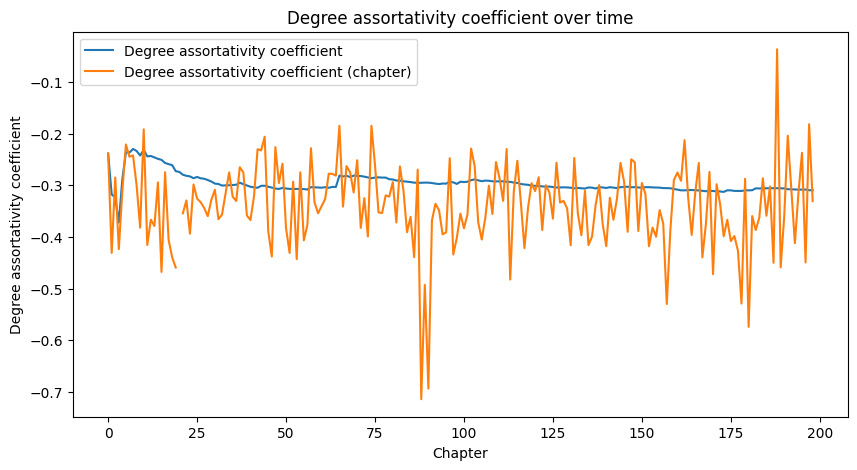

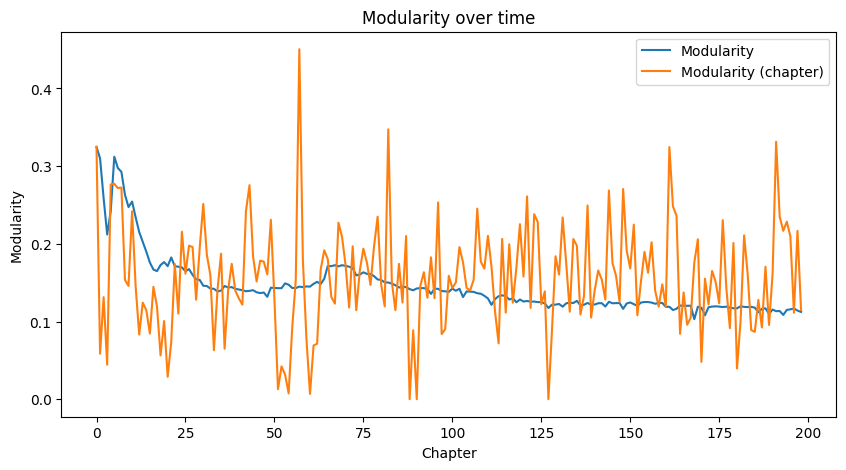

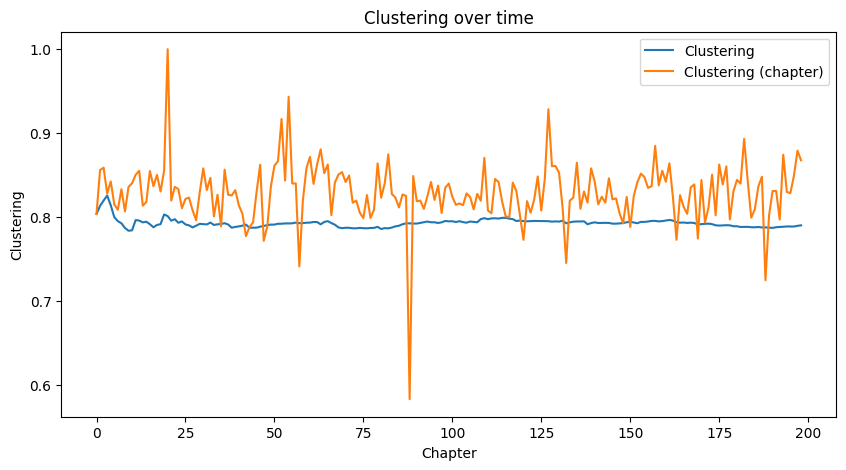

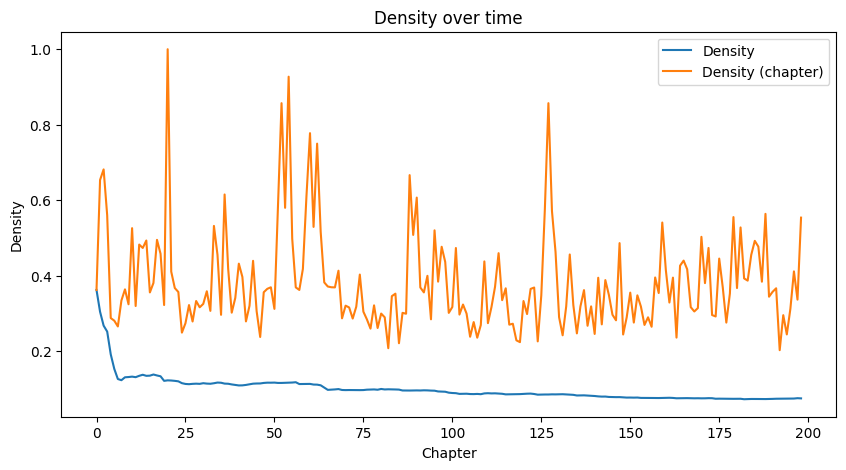

In [26]:
# Display degree assortativity coefficient over time

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(Degree_assortativity_time, label="Degree assortativity coefficient")
ax.plot(Degree_chap_assortativity_time, label="Degree assortativity coefficient (chapter)")
ax.set_xlabel("Chapter")
ax.set_ylabel("Degree assortativity coefficient")
ax.set_title("Degree assortativity coefficient over time")
ax.legend()
plt.show()

# Display modularity over time

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(Modularity_time, label="Modularity")
ax.plot(Modularity_chap_time, label="Modularity (chapter)")
ax.set_xlabel("Chapter")
ax.set_ylabel("Modularity")
ax.set_title("Modularity over time")
ax.legend()
plt.show()

# Display clustering over time

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(Clustering_time, label="Clustering")
ax.plot(Clustering_chap_time, label="Clustering (chapter)")
ax.set_xlabel("Chapter")
ax.set_ylabel("Clustering")
ax.set_title("Clustering over time")
ax.legend()
plt.show()

# Display density over time

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(Density_time, label="Density")
ax.plot(Density_chap_time, label="Density (chapter)")
ax.set_xlabel("Chapter")
ax.set_ylabel("Density")
ax.set_title("Density over time")
ax.legend()
plt.show()

In [11]:
community_louvain.modularity(partition, G)

0.16061073962907038

100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


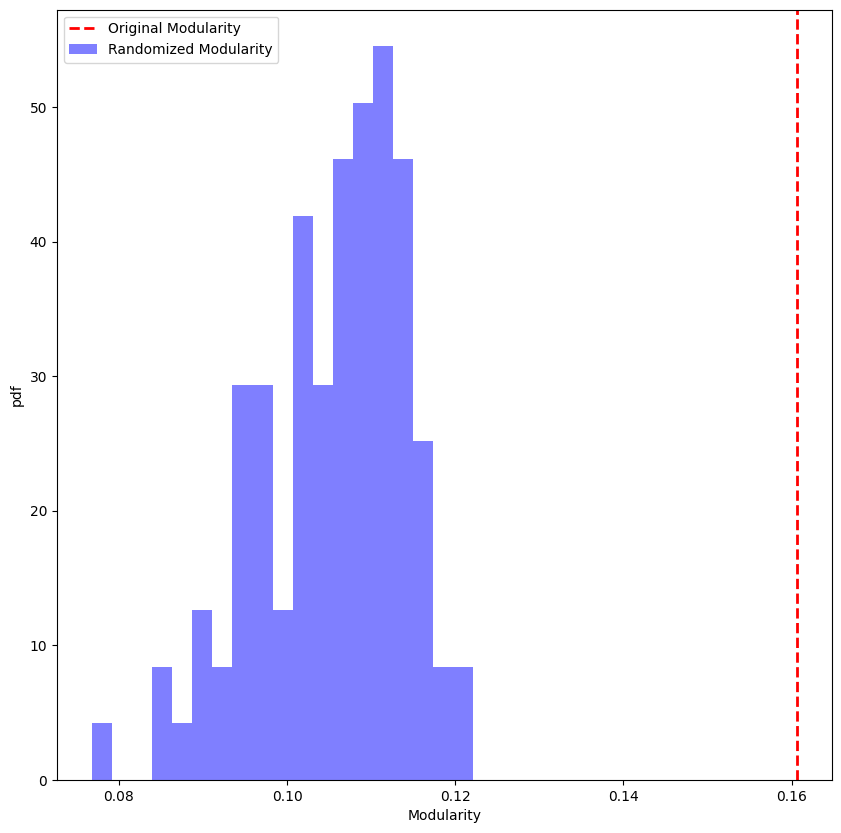

In [12]:
from Utils.Swap import ex_modularity

Modularity_values = ex_modularity(G, partition, n_swap=1000, experiments=100)

# plot histogram of modularity values
bins = np.linspace(min(Modularity_values), max(Modularity_values), 20)
hist, edges = np.histogram(Modularity_values, bins=bins, density=True)
x = (edges[:-1] + edges[1:]) / 2
width = bins[1] - bins[0]

fig , ax = plt.subplots(figsize=(10, 10))

ax.bar(x, hist, width=width, color='blue', alpha=0.5)

# Display Original Modularity as vertical line
ax.axvline(x=community_louvain.modularity(partition,G), color='red', linestyle='--', linewidth=2)
ax.legend(['Original Modularity', 'Randomized Modularity'])

plt.xlabel('Modularity')
plt.ylabel('pdf')

plt.show()


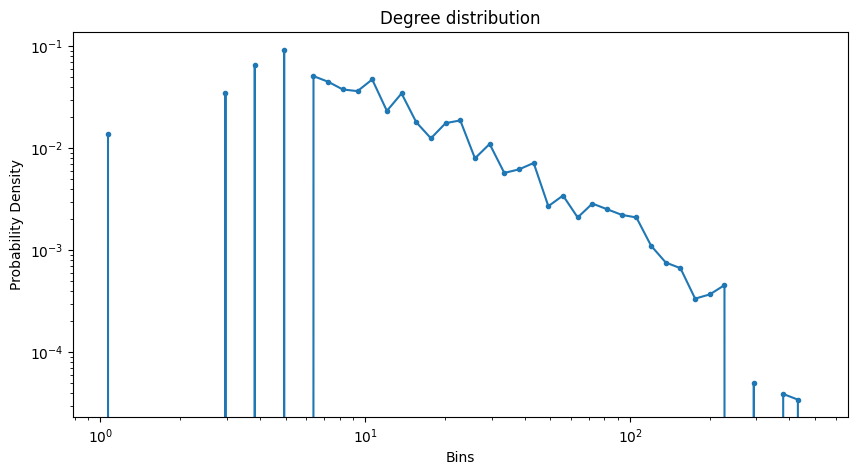

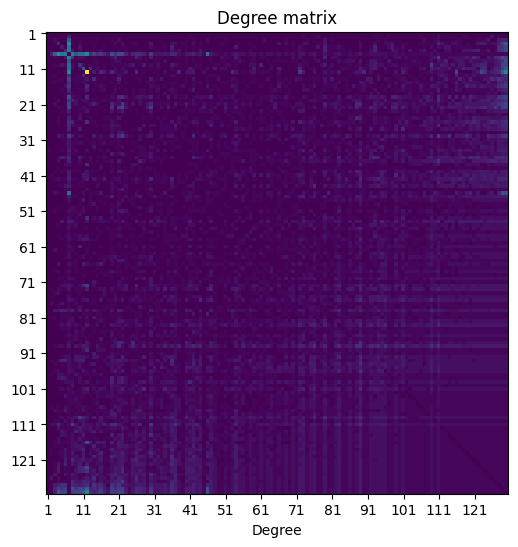

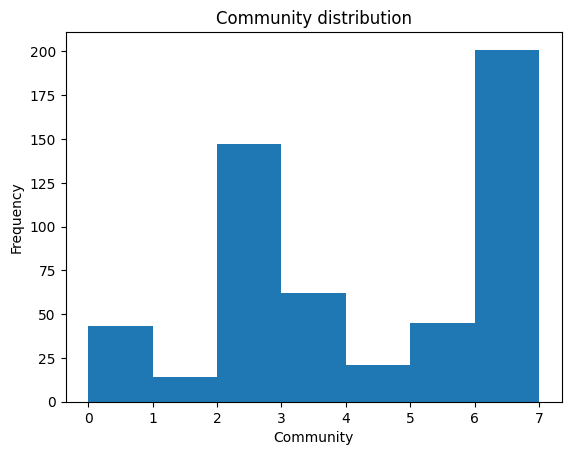

In [154]:
# Define functions for analysis

def degree_distribution(G,bins = 50,log = True):

    degrees = [G.degree(node) for node in G.nodes]


    # Plot the distribution of X_pareto
    bins = np.logspace(0, np.log10(max(degrees)), 50)
    hist, edges = np.histogram(degrees, bins=bins, density=True)
    x = (edges[1:]+edges[:-1])/2

    fig, ax = plt.subplots(figsize = (10,5))
    ax.plot(x, hist, marker = ".")
    ax.set_title(r"Degree distribution")
    ax.set_xlabel("Bins")
    ax.set_ylabel("Probability Density")
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.show()

def degree_matrix(G):

    degree_matrix = nx.degree_mixing_matrix(G)

    fig, ax = plt.subplots(1,1,figsize=(6,6))
    ax.imshow(degree_matrix)
    ax.set_title("Degree matrix")
    ax.set_xlabel("Degree")

    N = len(degree_matrix)

    ax.set_xticks(range(0,N,10))
    ax.set_xticklabels(range(1,N+1,10))

    ax.set_yticks(range(0,N,10))
    ax.set_yticklabels(range(1,N+1,10))

    plt.show()

def community_distribution(G):

    communities = [G.nodes[node]['group'] for node in G.nodes]

    plt.hist(communities, bins=range(0,max(communities)+1,1))
    plt.title("Community distribution")
    plt.xlabel("Community")
    plt.ylabel("Frequency")
    plt.show()



degree_distribution(G)
degree_matrix(G)
community_distribution(G)

TypeError: 'NoneType' object is not subscriptable

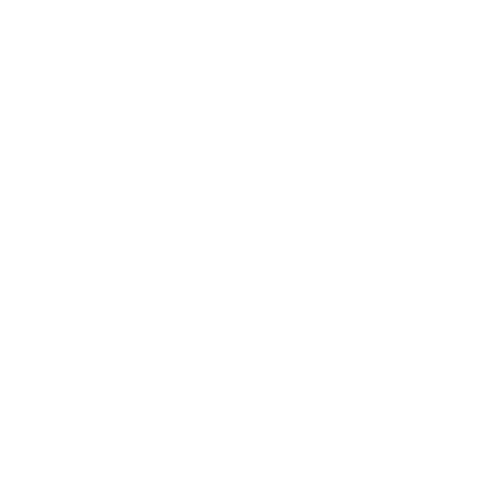

In [147]:
# Plot network
stylized_network, config  = nw.visualize(G)

fig, ax = nw.draw_netwulf(stylized_network)

# Add node labels
for node in G.nodes:
    nw.tools.add_node_label(ax, stylized_network, node)
plt.show()

# Plot network
stylized_network, config  = nw.visualize(G_chap)

fig, ax = nw.draw_netwulf(stylized_network)

# Add node labels
for node in G_chap.nodes:
    nw.tools.add_node_label(ax, stylized_network, node)
plt.show()



In [130]:
Boook_networks[1].nodes(data=True)["Harry Potter"]['sizes'][3] != 0

True

# Text

In [48]:


Characters_dynamic_text = {}

for char in tqdm(characters):
    Char_book_text = {}
    for book_nr in range(1,8):
        # Load formatted book (dict of chapters with list of lists of pages and sentences)
        with open(f"1.Dataset_files/Books_formatted/Book{book_nr}.pkl","rb") as f:
            book = pkl.load(f)
        
        Char_book_text[book_nr] = text_book(char['aliases'],book)


    Characters_dynamic_text[char['name']] = Char_book_text

with open(f"Temp/Dynamic_text.pkl","wb") as f:
    pkl.dump(Characters_dynamic_text,f)
   

100%|██████████| 677/677 [03:25<00:00,  3.29it/s] 


In [59]:
Characters_dynamic_text['Vernon Dursley']

{1: {1: ['last',
   'people',
   'expect',
   'involved',
   'anything',
   'strange',
   'mysterious',
   'hold',
   'nonsense',
   'dursley',
   'director',
   'firm',
   'called',
   'grunnings',
   'made',
   'drills',
   'big',
   'beefy',
   'man',
   'hardly',
   'neck',
   'although',
   'large',
   'mustache',
   'dursley',
   'woke',
   'dull',
   'gray',
   'tuesday',
   'story',
   'starts',
   'nothing',
   'cloudy',
   'sky',
   'outside',
   'suggest',
   'strange',
   'mysterious',
   'things',
   'would',
   'soon',
   'happening',
   'country',
   'dursley',
   'hummed',
   'picked',
   'boring',
   'tie',
   'work',
   'dursley',
   'gossiped',
   'away',
   'happily',
   'wrestled',
   'screaming',
   'dudley',
   'high',
   'chair',
   'none',
   'noticed',
   'large',
   'tawny',
   'owl',
   'flutter',
   'past',
   'window',
   'none',
   'noticed',
   'large',
   'tawny',
   'owl',
   'flutter',
   'past',
   'window',
   'half',
   'past',
   'eight',
   'durs

In [13]:
Characters_dynamic_text['Harry Potter'].keys()

dict_keys([7])